In [1]:

import pandas as pd
import numpy as np
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, TiDEModel
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss,MAE, RMSE, MAPE, SMAPE
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pytorch_forecasting.models import TimeXer
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import EarlyStopping,ModelCheckpoint
from lightning.pytorch.callbacks import Callback
from pytorch_forecasting.models import TimeXer
from pytorch_forecasting.models.nhits import NHiTS
import time




In [51]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [52]:
df = pd.read_csv("data/timexer_lambda.csv", parse_dates=["date"])
df = df.sort_values("date")
df["time_idx"] = (df["date"] - df["date"].min()).dt.total_seconds().astype(int)
df["series_id"] = 0

In [53]:
num_train = int(len(df) * 0.7)
num_test  = int(len(df) * 0.2)
num_vali  = len(df) - num_train - num_test

In [54]:
train_df = df.iloc[:num_train]
val_df   = df.iloc[num_train : num_train + num_vali]
test_df  = df.iloc[num_train + num_vali :]


In [55]:
max_encoder_length = 50
max_prediction_length = 1
static_categoricals = []
static_reals = []
time_varying_known_reals = [
    "bytes_op0","bytes_op1","bytes_sum","io_count",
    "read_ops_count","write_ops_count",
    "bytes_sum_ema_short","bytes_sum_ema_long",
    "bytes_sum_macd","bytes_sum_macd_signal",
]
time_varying_unknown_reals = ["duration_sum"]
group_ids = ["series_id"]
target = "duration_sum"
batch_size = 64
epochs = 50



In [56]:
covariate_scalers = {
    var: GroupNormalizer(groups=["series_id"]) 
    for var in time_varying_known_reals
}

In [57]:
model_kwargs = dict(
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=128,
    loss=QuantileLoss(quantiles=[0.1,0.5, 0.9]),  
    output_size=3,              # default: QuantileLoss
    logging_metrics=[SMAPE(),MAE(), RMSE(), MAPE()],
    log_interval=10,
    reduce_on_plateau_patience=4,
)


In [58]:
trainer_kwargs = dict(
    max_epochs=epochs,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.1,
)

In [59]:
# Horizons to run
horizons = [1, 5, 10, 15, 20]

In [60]:
class TimeAndLossCallback(Callback):
    def __init__(self, horizon):
        self.horizon = horizon
        self.epoch_times = []

    def on_train_epoch_start(self, trainer, pl_module):
        self.start_time = time.time()

    def on_train_epoch_end(self, trainer, pl_module):
        end_time = time.time()
        elapsed = end_time - self.start_time
        self.epoch_times.append(elapsed)

        epoch = trainer.current_epoch
        metrics = trainer.callback_metrics
        print(
            f"[H={self.horizon}] Epoch={epoch:02d}, "
            f"train_loss={metrics.get('train_loss'):.4f}, "
            f"val_loss={metrics.get('val_loss'):.4f}, "
            f"time={elapsed:.2f}s"
        )

    def on_train_end(self, trainer, pl_module):
        avg_time = np.mean(self.epoch_times)
        print(f"🕒 [H={self.horizon}] Average epoch time: {avg_time:.2f} seconds over {len(self.epoch_times)} epochs")


In [61]:
class PrintLossCallback(Callback):
    def __init__(self, horizon: int):
        super().__init__()
        self.horizon = horizon

    def on_train_epoch_end(self, trainer, pl_module):
        # logged_metrics is updated after validation, so both train_loss and val_loss should be present
        epoch = trainer.current_epoch
        metrics = trainer.callback_metrics
        train_loss = metrics.get("train_loss")
        val_loss   = metrics.get("val_loss")
        print(
            f"Horizon={self.horizon}  "
            f"Epoch={epoch:02d}  "
            f"train_loss={train_loss:.4f}  "
            f"val_loss={val_loss:.4f}"
        )

In [48]:
horizons = [1, 5, 10, 15, 20]
for horizon in horizons:
    print(f"\n🔁 Fine-tuning model for horizon = {horizon}")
    ckpt_path = f"checkpoints_no_static/horizon_{horizon}"
    best_ckpt_file = [f for f in os.listdir(ckpt_path) if f.endswith(".ckpt")]
    assert len(best_ckpt_file) == 1, f"Checkpoint missing in {ckpt_path}"
    best_ckpt = os.path.join(ckpt_path, best_ckpt_file[0])

    # Build dataset
    training = TimeSeriesDataSet(
        train_df,
        time_idx="time_idx",
        target=target,
        group_ids=group_ids,
        max_encoder_length=max_encoder_length,
        max_prediction_length=horizon,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
        scalers=covariate_scalers,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    validation = TimeSeriesDataSet.from_dataset(training, val_df, stop_randomization=True)

    train_loader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_loader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # Load model from checkpoint
    model = TemporalFusionTransformer.load_from_checkpoint(best_ckpt)

    # Callbacks
    ckpt_dir = f"ckpts_finetuned_polaris/horizon_{horizon}_finetuned"
    os.makedirs(ckpt_dir, exist_ok=True)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    checkpoint = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="finetuned-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
    )
    print_cb = PrintLossCallback(horizon)
    time_cb = TimeAndLossCallback(horizon)

    # Trainer
    trainer = Trainer(callbacks=[early_stop, checkpoint, print_cb, time_cb], **trainer_kwargs)

    # Fine-tune
    trainer.fit(model, train_loader, val_loader)

    print(f"✅ Fine-tuning complete for horizon {horizon}. Saved to {ckpt_dir}")


🔁 Fine-tuning model for horizon = 1


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=00  train_loss=0.0010  val_loss=0.0009
[H=1] Epoch=00, train_loss=0.0010, val_loss=0.0009, time=38.89s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=01  train_loss=0.0008  val_loss=0.0008
[H=1] Epoch=01, train_loss=0.0008, val_loss=0.0008, time=38.16s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=02  train_loss=0.0008  val_loss=0.0008
[H=1] Epoch=02, train_loss=0.0008, val_loss=0.0008, time=39.80s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=03  train_loss=0.0008  val_loss=0.0008
[H=1] Epoch=03, train_loss=0.0008, val_loss=0.0008, time=38.89s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=04  train_loss=0.0007  val_loss=0.0008
[H=1] Epoch=04, train_loss=0.0007, val_loss=0.0008, time=37.84s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=05  train_loss=0.0007  val_loss=0.0008
[H=1] Epoch=05, train_loss=0.0007, val_loss=0.0008, time=38.33s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=06  train_loss=0.0007  val_loss=0.0008
[H=1] Epoch=06, train_loss=0.0007, val_loss=0.0008, time=38.22s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=07  train_loss=0.0007  val_loss=0.0008
[H=1] Epoch=07, train_loss=0.0007, val_loss=0.0008, time=39.33s
🕒 [H=1] Average epoch time: 38.68 seconds over 8 epochs
✅ Fine-tuning complete for horizon 1. Saved to ckpts_finetuned_polaris/horizon_1_finetuned

🔁 Fine-tuning model for horizon = 5


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=00  train_loss=0.0011  val_loss=0.0010
[H=5] Epoch=00, train_loss=0.0011, val_loss=0.0010, time=38.85s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=01  train_loss=0.0009  val_loss=0.0009
[H=5] Epoch=01, train_loss=0.0009, val_loss=0.0009, time=40.04s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=02  train_loss=0.0009  val_loss=0.0009
[H=5] Epoch=02, train_loss=0.0009, val_loss=0.0009, time=39.27s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=03  train_loss=0.0008  val_loss=0.0009
[H=5] Epoch=03, train_loss=0.0008, val_loss=0.0009, time=39.79s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=04  train_loss=0.0008  val_loss=0.0010
[H=5] Epoch=04, train_loss=0.0008, val_loss=0.0010, time=38.71s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=05  train_loss=0.0008  val_loss=0.0009
[H=5] Epoch=05, train_loss=0.0008, val_loss=0.0009, time=39.66s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=06  train_loss=0.0008  val_loss=0.0009
[H=5] Epoch=06, train_loss=0.0008, val_loss=0.0009, time=40.46s
🕒 [H=5] Average epoch time: 39.54 seconds over 7 epochs
✅ Fine-tuning complete for horizon 5. Saved to ckpts_finetuned_polaris/horizon_5_finetuned

🔁 Fine-tuning model for horizon = 10


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=00  train_loss=0.0012  val_loss=0.0011
[H=10] Epoch=00, train_loss=0.0012, val_loss=0.0011, time=39.09s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=01  train_loss=0.0009  val_loss=0.0010
[H=10] Epoch=01, train_loss=0.0009, val_loss=0.0010, time=38.61s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=02  train_loss=0.0009  val_loss=0.0009
[H=10] Epoch=02, train_loss=0.0009, val_loss=0.0009, time=39.60s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=03  train_loss=0.0009  val_loss=0.0009
[H=10] Epoch=03, train_loss=0.0009, val_loss=0.0009, time=40.63s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=04  train_loss=0.0008  val_loss=0.0009
[H=10] Epoch=04, train_loss=0.0008, val_loss=0.0009, time=39.94s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=05  train_loss=0.0008  val_loss=0.0010
[H=10] Epoch=05, train_loss=0.0008, val_loss=0.0010, time=39.48s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=06  train_loss=0.0008  val_loss=0.0010
[H=10] Epoch=06, train_loss=0.0008, val_loss=0.0010, time=38.69s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=07  train_loss=0.0008  val_loss=0.0010
[H=10] Epoch=07, train_loss=0.0008, val_loss=0.0010, time=38.93s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=08  train_loss=0.0008  val_loss=0.0010
[H=10] Epoch=08, train_loss=0.0008, val_loss=0.0010, time=38.81s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=09  train_loss=0.0007  val_loss=0.0010
[H=10] Epoch=09, train_loss=0.0007, val_loss=0.0010, time=38.65s
🕒 [H=10] Average epoch time: 39.24 seconds over 10 epochs
✅ Fine-tuning complete for horizon 10. Saved to ckpts_finetuned_polaris/horizon_10_finetuned

🔁 Fine-tuning model for horizon = 15


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=00  train_loss=0.0011  val_loss=0.0010
[H=15] Epoch=00, train_loss=0.0011, val_loss=0.0010, time=38.33s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=01  train_loss=0.0009  val_loss=0.0010
[H=15] Epoch=01, train_loss=0.0009, val_loss=0.0010, time=39.28s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=02  train_loss=0.0009  val_loss=0.0011
[H=15] Epoch=02, train_loss=0.0009, val_loss=0.0011, time=39.94s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=03  train_loss=0.0008  val_loss=0.0011
[H=15] Epoch=03, train_loss=0.0008, val_loss=0.0011, time=40.03s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=04  train_loss=0.0008  val_loss=0.0010
[H=15] Epoch=04, train_loss=0.0008, val_loss=0.0010, time=39.31s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=05  train_loss=0.0008  val_loss=0.0011
[H=15] Epoch=05, train_loss=0.0008, val_loss=0.0011, time=39.31s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=06  train_loss=0.0007  val_loss=0.0011
[H=15] Epoch=06, train_loss=0.0007, val_loss=0.0011, time=39.54s
🕒 [H=15] Average epoch time: 39.39 seconds over 7 epochs
✅ Fine-tuning complete for horizon 15. Saved to ckpts_finetuned_polaris/horizon_15_finetuned

🔁 Fine-tuning model for horizon = 20


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=00  train_loss=0.0011  val_loss=0.0010
[H=20] Epoch=00, train_loss=0.0011, val_loss=0.0010, time=38.65s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=01  train_loss=0.0009  val_loss=0.0010
[H=20] Epoch=01, train_loss=0.0009, val_loss=0.0010, time=38.78s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=02  train_loss=0.0009  val_loss=0.0011
[H=20] Epoch=02, train_loss=0.0009, val_loss=0.0011, time=38.82s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=03  train_loss=0.0009  val_loss=0.0011
[H=20] Epoch=03, train_loss=0.0009, val_loss=0.0011, time=38.88s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=04  train_loss=0.0008  val_loss=0.0011
[H=20] Epoch=04, train_loss=0.0008, val_loss=0.0011, time=39.13s


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=05  train_loss=0.0008  val_loss=0.0011
[H=20] Epoch=05, train_loss=0.0008, val_loss=0.0011, time=40.60s
🕒 [H=20] Average epoch time: 39.14 seconds over 6 epochs
✅ Fine-tuning complete for horizon 20. Saved to ckpts_finetuned_polaris/horizon_20_finetuned


In [ ]:
for horizon in horizons:
    print(f"\n📊 Evaluating fine-tuned model for horizon = {horizon}")

    # Load original training dataset just for consistent normalization
    train_df = df.iloc[:num_train]
    training = TimeSeriesDataSet(
        train_df,
        time_idx="time_idx",
        target=target,
        group_ids=group_ids,
        max_encoder_length=max_encoder_length,
        max_prediction_length=horizon,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
        scalers=covariate_scalers,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    # Build test set using from_dataset
    test = TimeSeriesDataSet.from_dataset(training, test_df, stop_randomization=True)
    test_loader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # Load fine-tuned model
    ckpt_dir = f"checkpoints_no_static/horizon_{horizon}"
    ckpt_files = [f for f in os.listdir(ckpt_dir) if f.endswith(".ckpt")]
    assert len(ckpt_files) == 1, f"Expected one .ckpt file in {ckpt_dir}"
    best_ckpt = os.path.join(ckpt_dir, ckpt_files[0])
    model = TemporalFusionTransformer.load_from_checkpoint(best_ckpt)

    # Predict
    preds = model.predict(test_loader, return_x=False).detach().cpu().numpy().flatten()

    # True labels
    actuals = np.concatenate([y.detach().cpu().numpy()
                              for _, (y, _) in iter(test_loader)], axis=0).flatten()

    # Metrics
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    mape = mean_absolute_percentage_error(actuals, preds)
    smape = 100 * np.mean(2 * np.abs(actuals - preds) / (np.abs(actuals) + np.abs(preds) + 1e-8))

    print(f"✅ Test Metrics (horizon={horizon}):")
    print(f"   MSE   = {mse:.6f}")
    print(f"   RMSE  = {rmse:.6f}")
    print(f"   MAE   = {mae:.6f}")
    print(f"   MAPE  = {mape:.6%}")
    print(f"   SMAPE = {smape:.6f}%")


📊 Evaluating fine-tuned model for horizon = 1


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmod

✅ Test Metrics (horizon=1):
   MSE   = 0.003662
   RMSE  = 0.060517
   MAE   = 0.005664
   MAPE  = 120.505559%
   SMAPE = 66.172310%

📊 Evaluating fine-tuned model for horizon = 5


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmod

✅ Test Metrics (horizon=5):
   MSE   = 0.003669
   RMSE  = 0.060569
   MAE   = 0.006519
   MAPE  = 168.334651%
   SMAPE = 80.595123%

📊 Evaluating fine-tuned model for horizon = 10


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmod

✅ Test Metrics (horizon=10):
   MSE   = 0.003666
   RMSE  = 0.060545
   MAE   = 0.005820
   MAPE  = 135.546577%
   SMAPE = 70.257637%

📊 Evaluating fine-tuned model for horizon = 15


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmod

✅ Test Metrics (horizon=15):
   MSE   = 0.003740
   RMSE  = 0.061158
   MAE   = 0.007269
   MAPE  = 194.599295%
   SMAPE = 87.836304%

📊 Evaluating fine-tuned model for horizon = 20


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmod

✅ Test Metrics (horizon=20):
   MSE   = 0.003679
   RMSE  = 0.060656
   MAE   = 0.008731
   MAPE  = 548.700094%
   SMAPE = 105.543114%


: 

In [31]:
best_model = TemporalFusionTransformer.load_from_checkpoint("ckpts_finetuned_polaris/horizon_20_finetuned/finetuned-epoch=00-val_loss=0.0010.ckpt")

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [32]:
training = TimeSeriesDataSet(
        train_df,
        time_idx="time_idx",
        target=target,
        group_ids=group_ids,
        max_encoder_length=max_encoder_length,
        max_prediction_length=20,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
        scalers=covariate_scalers,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
validation = TimeSeriesDataSet.from_dataset(training, val_df, stop_randomization=True)

train_loader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_loader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test = TimeSeriesDataSet.from_dataset(training, test_df, stop_randomization=True)
test_loader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [33]:
raw_predictions = best_model.predict(
    test_loader,
    mode="raw",
    return_x=True,
 
)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

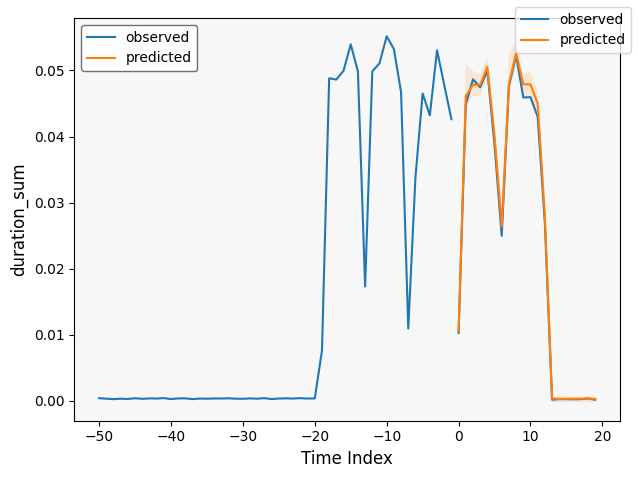

In [35]:
idx=250
fig = best_model.plot_prediction( raw_predictions.x, 
    raw_predictions.output, idx=idx,plot_attention=False
)
ax = fig.axes[0]
# 3) Now customize! For example:
#    – change background
ax.set_facecolor("#f7f7f7")

#    – tweak the legend
leg = ax.legend(loc="upper left", frameon=True)
leg.get_frame().set_edgecolor("0.3")
leg.get_frame().set_linewidth(1.0)



ax.set_xlabel("Time Index", fontsize=12)
ax.set_ylabel("duration_sum", fontsize=12)


plt.tight_layout()
plt.show()